## Uczenie maszynowe UMZ 2019/2020
### 26 maja 2020
# 11. Wielowarstwowe sieci neuronowe i algorytmy optymalizacji

## 11.1. Funkcje aktywacji

* Każda funkcja aktywacji ma swoje zalety i wady.
* Różne rodzaje funkcji aktywacji nadają się do różnych zastosowań.

In [1]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import random

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.optimizers import Adagrad, Adam, RMSprop, SGD

from IPython.display import YouTubeVideo

/home/pawel/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot(fun):
    x = np.arange(-3.0, 3.0, 0.01)
    y = [fun(x_i) for x_i in x]
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.set_xlim(-3.0, 3.0)
    ax.set_ylim(-1.5, 1.5)
    ax.grid()
    ax.plot(x, y)
    plt.show()

### Funkcja logistyczna

$$ g(x) = \frac{1}{1 + e^{-x}} $$

* Przyjmuje wartości z przedziału $(0, 1)$.

#### Funkcja logistyczna – wykres

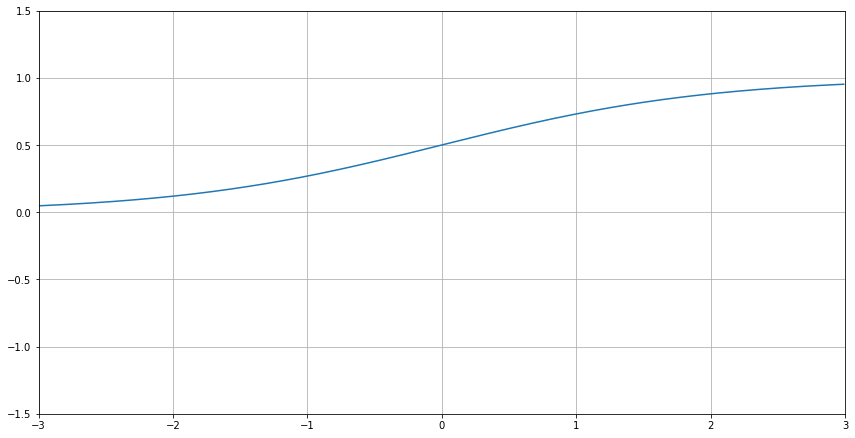

In [3]:
plot(lambda x: 1 / (1 + math.exp(-x)))

### Tangens hiperboliczny

$$ g(x) = \tanh x = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} $$

* Przyjmuje wartości z przedziału $(-1, 1)$.
* Powstaje z funkcji logistycznej przez przeskalowanie i przesunięcie.

#### Tangens hiperboliczny – wykres

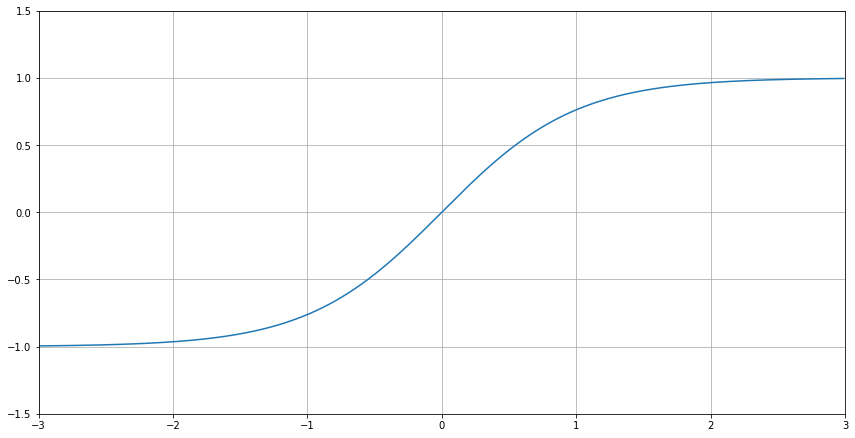

In [4]:
plot(lambda x: math.tanh(x))

### ReLU (_Rectifier Linear Unit_)

$$ g(x) = \max(0, x) $$

#### ReLU – zalety
* Mniej podatna na problem zanikającego gradientu (_vanishing gradient_) niż funkcje sigmoidalne, dzięki czemu SGD jest szybciej zbieżna.
* Prostsze obliczanie gradientu.
* Dzięki zerowaniu ujemnych wartości, wygasza neurony, „rozrzedzając” sieć (_sparsity_), co przyspiesza obliczenia.

#### ReLU – wady
* Dla dużych wartości gradient może „eksplodować”.
* „Wygaszanie” neuronów.

#### ReLU – wykres

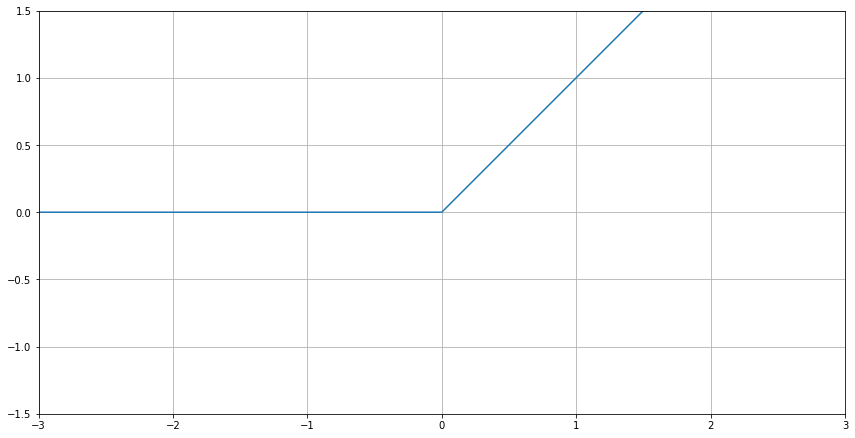

In [5]:
plot(lambda x: max(0, x))

### Softplus

$$ g(x) = \log(1 + e^{x}) $$

* Wygładzona wersja ReLU.

#### Softplus – wykres

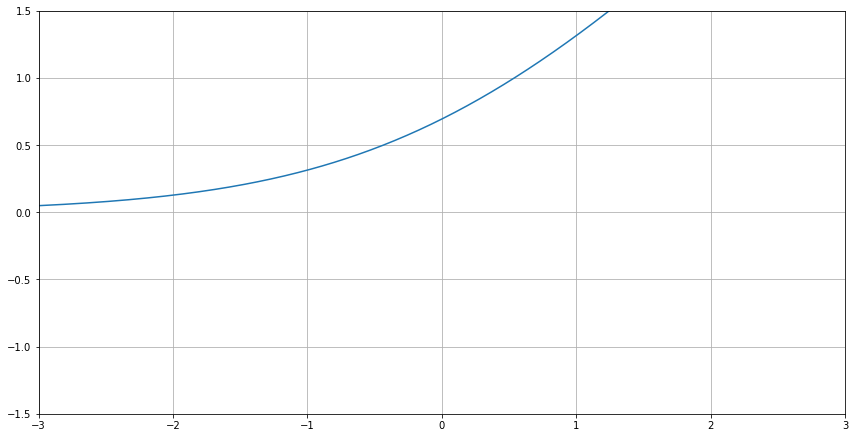

In [6]:
plot(lambda x: math.log(1 + math.exp(x)))

### Problem zanikającego gradientu (_vanishing gradient problem_)

* Sigmoidalne funkcje aktywacji ograniczają wartości na wyjściach neuronów do niewielkich przedziałów ($(-1, 1)$, $(0, 1)$ itp.).
* Jeżeli sieć ma wiele warstw, to podczas propagacji wstecznej mnożymy przez siebie wiele małych wartości → obliczony gradient jest mały.
* Im więcej warstw, tym silniejszy efekt zanikania.

#### Sposoby na zanikający gradient

* Modyfikacja algorytmu optymalizacji (_RProp_, _RMSProp_)
* Użycie innej funckji aktywacji (ReLU, softplus)
* Dodanie warstw _dropout_
* Nowe architektury (LSTM itp.)
* Więcej danych, zwiększenie mocy obliczeniowej

## 11.2. Wielowarstwowe sieci neuronowe w&nbsp;praktyce

### Przykład: MNIST

_Modified National Institute of Standards and Technology database_

* Zbiór cyfr zapisanych pismem odręcznym
* 60 000 przykładów uczących, 10 000 przykładów testowych
* Rozdzielczość każdego przykładu: 28 × 28 = 784 piksele

In [7]:
# źródło: https://github.com/keras-team/keras/examples/minst_mlp.py

import keras
from keras.datasets import mnist

# załaduj dane i podziel je na zbiory uczący i testowy
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [8]:
def draw_examples(examples, captions=None):
    plt.figure(figsize=(16, 4))
    m = len(examples)
    for i, example in enumerate(examples):
        plt.subplot(100 + m * 10 + i + 1)
        plt.imshow(example, cmap=plt.get_cmap('gray'))
    plt.show()
    if captions is not None:
        print(6 * ' ' + (10 * ' ').join(str(captions[i]) for i in range(m)))

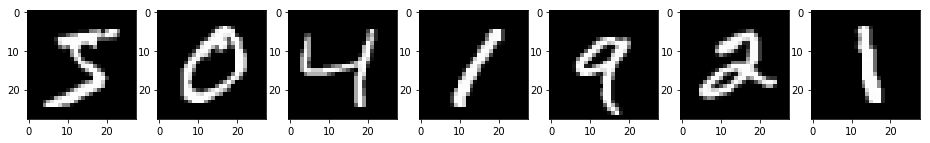

      5          0          4          1          9          2          1


In [9]:
draw_examples(x_train[:7], captions=y_train)

In [10]:
num_classes = 10

x_train = x_train.reshape(60000, 784)  # 784 = 28 * 28
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('{} przykładów uczących'.format(x_train.shape[0]))
print('{} przykładów testowych'.format(x_test.shape[0]))

# przekonwertuj wektory klas na binarne macierze klas
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 przykładów uczących
10000 przykładów testowych


In [11]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [12]:
print(x_train.shape, y_train.shape)

((60000, 784), (60000, 10))


In [13]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 9s 153us/step - loss: 0.2489 - acc: 0.9224 - val_loss: 0.1005 - val_acc: 0.9706
Epoch 2/5
60000/60000 [==============================] - 9s 151us/step - loss: 0.1042 - acc: 0.9683 - val_loss: 0.0861 - val_acc: 0.9740
Epoch 3/5
60000/60000 [==============================] - 9s 153us/step - loss: 0.0742 - acc: 0.9782 - val_loss: 0.0733 - val_acc: 0.9796
Epoch 4/5
60000/60000 [==============================] - 9s 154us/step - loss: 0.0603 - acc: 0.9824 - val_loss: 0.0713 - val_acc: 0.9800
Epoch 5/5
60000/60000 [==============================] - 9s 157us/step - loss: 0.0512 - acc: 0.9848 - val_loss: 0.0749 - val_acc: 0.9795


In [15]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.074858742202
Test accuracy: 0.9795


Warstwa _dropout_ to metoda regularyzacji, służy zapobieganiu nadmiernemu dopasowaniu sieci. Polega na tym, że część węzłów sieci jest usuwana w sposób losowy.

In [16]:
# Bez warstw Dropout

num_classes = 10

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)  # 784 = 28 * 28
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model_no_dropout = Sequential()
model_no_dropout.add(Dense(512, activation='relu', input_shape=(784,)))
model_no_dropout.add(Dense(512, activation='relu'))
model_no_dropout.add(Dense(num_classes, activation='softmax'))
model_no_dropout.summary()

model_no_dropout.compile(loss='categorical_crossentropy',
                         optimizer=RMSprop(),
                         metrics=['accuracy'])

model_no_dropout.fit(x_train, y_train,
                     batch_size=128,
                     epochs=5,
                     verbose=1,
                     validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 139us/step - loss: 0.2237 - acc: 0.9303 - val_loss: 0.0998 - val_acc: 0.9676
Epoch 2/5
60000/60000 [==============================] - 8s 136us/step - loss: 0.0818 - acc: 0.9748 - val_loss: 0.0788 - val_acc: 0.9770
Epoch 3/5
60000/60000 [==============================] - 8s 136us/step - los

In [17]:
# Bez warstw Dropout

score = model_no_dropout.evaluate(x_test, y_test, verbose=0)

print('Test loss (no dropout): {}'.format(score[0]))
print('Test accuracy (no dropout): {}'.format(score[1]))

Test loss (no dropout): 0.0753162465898
Test accuracy (no dropout): 0.9812


In [18]:
# Więcej warstw, inna funkcja aktywacji

num_classes = 10

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)  # 784 = 28 * 28
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model3 = Sequential()
model3.add(Dense(2500, activation='tanh', input_shape=(784,)))
model3.add(Dense(2000, activation='tanh'))
model3.add(Dense(1500, activation='tanh'))
model3.add(Dense(1000, activation='tanh'))
model3.add(Dense(500, activation='tanh'))
model3.add(Dense(num_classes, activation='softmax'))
model3.summary()

model3.compile(loss='categorical_crossentropy',
               optimizer=RMSprop(),
               metrics=['accuracy'])

model3.fit(x_train, y_train,
           batch_size=128,
           epochs=10,
           verbose=1,
           validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 2500)              1962500   
_________________________________________________________________
dense_8 (Dense)              (None, 2000)              5002000   
_________________________________________________________________
dense_9 (Dense)              (None, 1500)              3001500   
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              1501000   
_________________________________________________________________
dense_11 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5010      
Total params: 11,972,510
Trainable params: 11,972,510
Non-trainable params: 0
________________________________________________________________

In [19]:
# Więcej warstw, inna funkcja aktywacji

score = model3.evaluate(x_test, y_test, verbose=0)

print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.107020105763
Test accuracy: 0.9718


### Przykład: 4-pikselowy aparat fotograficzny

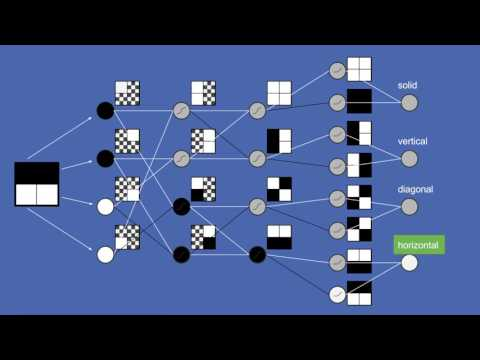

In [32]:
YouTubeVideo('ILsA4nyG7I0', width=800, height=600)

In [33]:
def generate_example(description):
    variant = random.choice([1, -1])
    if description == 's':  # solid
        return (np.array([[ 1.0,  1.0], [ 1.0,  1.0]]) if variant == 1 else
                np.array([[-1.0, -1.0], [-1.0, -1.0]]))
    elif description == 'v':  # vertical
        return (np.array([[ 1.0, -1.0], [ 1.0, -1.0]]) if variant == 1 else
                np.array([[-1.0,  1.0], [-1.0,  1.0]]))
    elif description == 'd':  # diagonal
        return (np.array([[ 1.0, -1.0], [-1.0,  1.0]]) if variant == 1 else
                np.array([[-1.0,  1.0], [ 1.0, -1.0]]))
    elif description == 'h':  # horizontal
        return (np.array([[ 1.0,  1.0], [-1.0, -1.0]]) if variant == 1 else
                np.array([[-1.0, -1.0], [ 1.0,  1.0]]))
    else:
        return np.array([[random.uniform(-1, 1), random.uniform(-1, 1)],
                         [random.uniform(-1, 1), random.uniform(-1, 1)]])

In [34]:
num_classes = 4

trainset_size = 4000
testset_size = 1000

y4_train = np.array([random.choice(['s', 'v', 'd', 'h']) for i in range(trainset_size)])
x4_train = np.array([generate_example(desc) for desc in y4_train])

y4_test = np.array([random.choice(['s', 'v', 'd', 'h']) for i in range(testset_size)])
x4_test = np.array([generate_example(desc) for desc in y4_test])

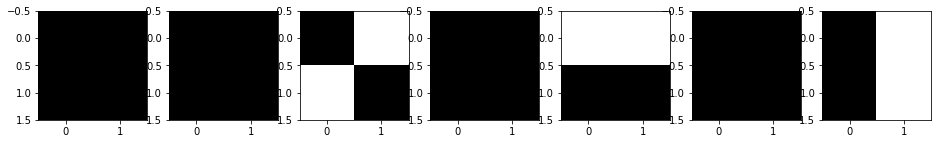

      s          s          d          s          h          s          v


In [35]:
draw_examples(x4_train[:7], captions=y4_train)

In [36]:
x4_train = x4_train.reshape(trainset_size, 4)
x4_test = x4_test.reshape(testset_size, 4)
x4_train = x4_train.astype('float32')
x4_test = x4_test.astype('float32')

y4_train = np.array([{'s': 0, 'v': 1, 'd': 2, 'h': 3}[desc] for desc in y4_train])
y4_test = np.array([{'s': 0, 'v': 1, 'd': 2, 'h': 3}[desc] for desc in y4_test])

y4_train = keras.utils.to_categorical(y4_train, num_classes)
y4_test = keras.utils.to_categorical(y4_test, num_classes)

In [37]:
model4 = Sequential()
model4.add(Dense(4, activation='tanh', input_shape=(4,)))
model4.add(Dense(4, activation='tanh'))
model4.add(Dense(8, activation='relu'))
model4.add(Dense(num_classes, activation='softmax'))
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 36        
Total params: 116
Trainable params: 116
Non-trainable params: 0
_________________________________________________________________


In [38]:
model4.layers[0].set_weights(
    [np.array([[ 1.0,  0.0,  1.0,  0.0],
               [ 0.0,  1.0,  0.0,  1.0],
               [ 1.0,  0.0, -1.0,  0.0],
               [ 0.0,  1.0,  0.0, -1.0]],
              dtype=np.float32), np.array([0., 0., 0., 0.], dtype=np.float32)])
model4.layers[1].set_weights(
    [np.array([[ 1.0, -1.0,  0.0,  0.0],
               [ 1.0,  1.0,  0.0,  0.0],
               [ 0.0,  0.0,  1.0, -1.0],
               [ 0.0,  0.0, -1.0, -1.0]],
              dtype=np.float32), np.array([0., 0., 0., 0.], dtype=np.float32)])
model4.layers[2].set_weights(
    [np.array([[ 1.0, -1.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0],
               [ 0.0,  0.0,  1.0, -1.0,  0.0,  0.0,  0.0,  0.0],
               [ 0.0,  0.0,  0.0,  0.0,  1.0, -1.0,  0.0,  0.0],
               [ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  1.0, -1.0]],
              dtype=np.float32), np.array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=np.float32)])

In [39]:
model4.layers[3].set_weights(
    [np.array([[ 1.0,  0.0,  0.0,  0.0],
               [ 1.0,  0.0,  0.0,  0.0],
               [ 0.0,  1.0,  0.0,  0.0],
               [ 0.0,  1.0,  0.0,  0.0],
               [ 0.0,  0.0,  1.0,  0.0],
               [ 0.0,  0.0,  1.0,  0.0],
               [ 0.0,  0.0,  0.0,  1.0],
               [ 0.0,  0.0,  0.0,  1.0]],
              dtype=np.float32), np.array([0., 0., 0., 0.], dtype=np.float32)])

model4.compile(loss='categorical_crossentropy',
               optimizer=Adagrad(),
               metrics=['accuracy'])

In [40]:
for layer in model4.layers:
    print(layer.get_weights())

[array([[ 1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  1.],
       [ 1.,  0., -1.,  0.],
       [ 0.,  1.,  0., -1.]], dtype=float32), array([ 0.,  0.,  0.,  0.], dtype=float32)]
[array([[ 1., -1.,  0.,  0.],
       [ 1.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -1.],
       [ 0.,  0., -1., -1.]], dtype=float32), array([ 0.,  0.,  0.,  0.], dtype=float32)]
[array([[ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1.]], dtype=float32), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)]
[array([[ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.]], dtype=float32), array([ 0.,  0.,  0.,  0.], dtype=float32)]


In [41]:
model4.predict([np.array([[1.0, 1.0], [-1.0, -1.0]]).reshape(1, 4)])

array([[ 0.17831734,  0.17831734,  0.17831734,  0.46504799]], dtype=float32)

In [42]:
score = model4.evaluate(x4_test, y4_test, verbose=0)

print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.765614629269
Test accuracy: 1.0


In [43]:
model5 = Sequential()
model5.add(Dense(4, activation='tanh', input_shape=(4,)))
model5.add(Dense(4, activation='tanh'))
model5.add(Dense(8, activation='relu'))
model5.add(Dense(num_classes, activation='softmax'))
model5.compile(loss='categorical_crossentropy',
               optimizer=RMSprop(),
               metrics=['accuracy'])
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 36        
Total params: 116
Trainable params: 116
Non-trainable params: 0
_________________________________________________________________


In [44]:
model5.fit(x4_train, y4_train, epochs=8, validation_data=(x4_test, y4_test))

Train on 4000 samples, validate on 1000 samples
Epoch 1/8
4000/4000 [==============================] - 0s - loss: 1.1352 - acc: 0.5507 - val_loss: 1.0160 - val_acc: 0.7330
Epoch 2/8
4000/4000 [==============================] - 0s - loss: 0.8918 - acc: 0.8722 - val_loss: 0.8094 - val_acc: 0.8580
Epoch 3/8
4000/4000 [==============================] - 0s - loss: 0.6966 - acc: 0.8810 - val_loss: 0.6283 - val_acc: 0.8580
Epoch 4/8
4000/4000 [==============================] - 0s - loss: 0.5284 - acc: 0.8810 - val_loss: 0.4697 - val_acc: 0.8580
Epoch 5/8
4000/4000 [==============================] - 0s - loss: 0.3797 - acc: 0.9022 - val_loss: 0.3312 - val_acc: 1.0000
Epoch 6/8
4000/4000 [==============================] - 0s - loss: 0.2555 - acc: 1.0000 - val_loss: 0.2166 - val_acc: 1.0000
Epoch 7/8
4000/4000 [==============================] - 0s - loss: 0.1612 - acc: 1.0000 - val_loss: 0.1318 - val_acc: 1.0000
Epoch 8/8
4000/4000 [==============================] - 0s - loss: 0.0939 - acc: 1.00

In [45]:
model5.predict([np.array([[1.0, 1.0], [-1.0, -1.0]]).reshape(1, 4)])

array([[ 0.00708295,  0.00192736,  0.02899081,  0.96199888]], dtype=float32)

In [46]:
score = model5.evaluate(x4_test, y4_test, verbose=0)

print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.0731911802292
Test accuracy: 1.0


In [47]:
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)

In [48]:
with printoptions(precision=1, suppress=True):
    for layer in model5.layers:
        print(layer.get_weights())

[array([[-0.2, -0.5,  0.8,  1. ],
       [-0.9,  0.1, -0.8,  0.2],
       [-0.2,  0.4,  0.1, -0.4],
       [-0.8,  0.8,  1. ,  0.3]], dtype=float32), array([ 0. , -0. ,  0.1, -0.1], dtype=float32)]
[array([[-0.4,  0.9, -1.3,  1.7],
       [-0.4, -0.7,  0.3, -0.3],
       [ 0.8, -0.9, -1.1, -0.2],
       [ 1.3,  0.5,  0.4, -0.2]], dtype=float32), array([-0. , -0. ,  0.2,  0. ], dtype=float32)]
[array([[-1.6,  0.3,  0.3, -0.3, -1.1,  1.2,  0.7, -1. ],
       [ 0.4,  1.3, -0.9,  0.8, -0.4, -0.7, -1.2, -1. ],
       [ 0.6,  1. ,  0.9, -1. , -1.1, -0.2, -0.4, -0.3],
       [ 1.1,  0.1, -0.9,  1.3, -0.3, -0.2,  0.2, -0.4]], dtype=float32), array([-0. ,  0.2, -0.1,  0. , -0.1, -0. , -0.1,  0.1], dtype=float32)]
[array([[ 0.6, -1.5,  1.3, -1.4],
       [-0.4, -1.6, -0.3,  1.2],
       [ 1.2,  1.1, -0.3, -1.5],
       [ 0.6,  1.4, -1.5, -1.2],
       [ 0.2, -1.3, -0.9,  0.8],
       [ 0.6, -1.5,  0.8, -1. ],
       [ 0.4, -1.3,  0.4,  0.3],
       [-1.3,  0.5, -0.9,  0.8]], dtype=float32), arra

## 12.3. Odmiany metody gradientu prostego

* Batch gradient descent
* Stochastic gradient descent
* Mini-batch gradient descent

### _Batch gradient descent_

* Klasyczna wersja metody gradientu prostego
* Obliczamy gradient funkcji kosztu względem całego zbioru treningowego:
  $$ \theta := \theta - \alpha \cdot \nabla_\theta J(\theta) $$
* Dlatego może działać bardzo powoli
* Nie można dodawać nowych przykładów na bieżąco w trakcie trenowania modelu (_online learning_)

### _Stochastic gradient descent_ (SGD)

* Aktualizacja parametrów dla każdego przykładu:
  $$ \theta := \theta - \alpha \cdot \nabla_\theta \, J \! \left( \theta, x^{(i)}, y^{(i)} \right) $$
* Dużo szybszy niż _batch gradient descent_
* Można dodawać nowe przykłady na bieżąco w trakcie trenowania (_online learning_)

### _Stochastic gradient descent_ (SGD)

* Częsta aktualizacja parametrów z dużą wariancją:

<img src="http://ruder.io/content/images/2016/09/sgd_fluctuation.png" style="margin: auto;" width="50%" />

* Z jednej strony dzięki temu nie utyka w złych minimach lokalnych, ale z drugiej strony może „wyskoczyć” z dobrego minimum

### _Mini-batch gradient descent_

* Kompromis między _batch gradient descent_ i SGD
  $$ \theta := \theta - \alpha \cdot \nabla_\theta \, J \left( \theta, x^{(i : i+n)}, y^{(i : i_n)} \right) $$
* Stabilniejsza zbieżność dzięki redukcji wariancji aktualizacji parametrów
* Szybszy niż klasyczny _batch gradient descent_
* Typowa wielkość batcha: między 50 a 256 przykładów

### Wady klasycznej metody gradientu prostego, czyli dlaczego potrzebujemy optymalizacji

* Trudno dobrać właściwą szybkość uczenia (_learning rate_)
* Jedna ustalona wartość stałej uczenia się dla wszystkich parametrów
* Funkcja kosztu dla sieci neuronowych nie jest wypukła, więc uczenie może utknąć w złym minimum lokalnym lub punkcie siodłowym

## 12.4. Algorytmy optymalizacji metody gradientu

* Momentum
* Nesterov Accelerated Gradient
* Adagrad
* Adadelta
* RMSprop
* Adam
* Nadam
* AMSGrad

### Momentum

* SGD źle radzi sobie w „wąwozach” funkcji kosztu
* Momentum rozwiązuje ten problem przez dodanie współczynnika $\gamma$, który można trakować jako „pęd” spadającej piłki:
  $$ v_t := \gamma \, v_{t-1} + \alpha \, \nabla_\theta J(\theta) $$
  $$ \theta := \theta - v_t $$

### Przyspiesony gradient Nesterova (_Nesterov Accelerated Gradient_, NAG)

* Momentum czasami powoduje niekontrolowane rozpędzanie się piłki, przez co staje się „mniej sterowna”
* Nesterov do piłki posiadającej pęd dodaje „hamulec”, który spowalnia piłkę przed wzniesieniem:
  $$ v_t := \gamma \, v_{t-1} + \alpha \, \nabla_\theta J(\theta - \gamma \, v_{t-1}) $$
  $$ \theta := \theta - v_t $$

### Adagrad

* “<b>Ada</b>ptive <b>grad</b>ient”
* Adagrad dostosowuje współczynnik uczenia (_learning rate_) do parametrów: zmniejsza go dla cech występujących częściej, a zwiększa dla występujących rzadziej
* Świetny do trenowania na rzadkich (_sparse_) zbiorach danych
* Wada: współczynnik uczenia może czasami gwałtownie maleć

### Adadelta i RMSprop
* Warianty algorytmu Adagrad, które radzą sobie z problemem gwałtownych zmian współczynnika uczenia

### Adam

* “<b>Ada</b>ptive <b>m</b>oment estimation”
* Łączy zalety algorytmów RMSprop i Momentum
* Można go porównać do piłki mającej ciężar i opór
* Obecnie jeden z najpopularniejszych algorytmów optymalizacji

### Nadam
* “<b>N</b>esterov-accelerated <b>ada</b>ptive <b>m</b>oment estimation”
* Łączy zalety algorytmów Adam i Nesterov Accelerated Gradient

### AMSGrad
* Wariant algorytmu Adam lepiej dostosowany do zadań takich jak rozpoznawanie obiektów czy tłumaczenie maszynowe

<img src="contours_evaluation_optimizers.gif" style="margin: auto;" width="80%" />

<img src="saddle_point_evaluation_optimizers.gif" style="margin: auto;" width="80%" />